In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import argparse
import os
import re
import soundfile as sf
import librosa

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Lambda, Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend as K

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
# import eli5
# from eli5.sklearn import PermutationImportance

import pickle
import joblib

## wav -> feature dataframe

In [ ]:
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512 # number audio of frames between STFT columns
WAV_LENGTH = 661794 # 기존 30초짜리 wav 파일의 length

col_name = ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
            'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var',
            'rolloff_mean','rolloff_var', 'zero_crossing_rate_mean','zero_crossing_rate_var', 'harmony_mean',
            'harmony_var','perceptr_mean','perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var',
            'mfcc3_mean','mfcc3_var','mfcc4_mean', 'mfcc4_var','mfcc5_mean', 'mfcc5_var','mfcc6_mean','mfcc6_var',
            'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean',
            'mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var',
            'mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var', 'mfcc16_mean','mfcc16_var', 'mfcc17_mean',
            'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var','mfcc20_mean', 'mfcc20_var']

# 30 sec
# wav 파일 하나 -> 30sec feature extraction -> dataframe
def table_arr(wav_data):
  n_li = []
  y, sr = librosa.load(wav_data)
  audio_file, _ = librosa.effects.trim(y)

  # file_name
  n_li.append(str(wav_data)[34:])   # 파일명에 따라 변경..
  # length
  n_li.append(len(audio_file))
  # chroma_stft
  chroma_stft = librosa.feature.chroma_stft(audio_file, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(chroma_stft))
  n_li.append(np.var(chroma_stft))
  # rms
  rms = librosa.feature.rms(audio_file, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(rms))
  n_li.append(np.var(rms))
  # spectral_centroid
  spec_cent = librosa.feature.spectral_centroid(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(spec_cent))
  n_li.append(np.var(spec_cent))
  # spectral_bandwidth
  spec_bw = librosa.feature.spectral_bandwidth(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(spec_bw))
  n_li.append(np.var(spec_bw))
  # rolloff
  rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(rolloff))
  n_li.append(np.var(rolloff))
  # zero_crossing_rate
  zcr = librosa.feature.zero_crossing_rate(audio_file, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(zcr))
  n_li.append(np.var(zcr))
  # harmony
  harmony = librosa.effects.harmonic(audio_file)
  n_li.append(np.mean(harmony))
  n_li.append(np.var(harmony))
  # perceptr
  perc = librosa.effects.percussive(audio_file)
  n_li.append(np.mean(perc))
  n_li.append(np.var(perc))
  # tempo
  tempo = librosa.beat.tempo(audio_file)
  n_li.append(tempo[0])
  # mfcc
  mfccs = librosa.feature.mfcc(y=audio_file, sr=sr)
  for i in range(len(mfccs)):
    n_li.append(np.mean(mfccs[i]))
    n_li.append(np.var(mfccs[i]))
  
  return n_li

def feature_30_sec(wav_data):
  n_li = table_arr(wav_data)
  df_30 = pd.DataFrame([n_li], columns=col_name)
  return df_30


# 3 sec
# wav(30sec) -> 3sec짜리 wav로 쪼개기
def trim_audio(wav_data, y, sr):
  sec = 3   # 3초짜리
  audio_file, _ = librosa.effects.trim(y)
  
  # 기존 30초 wav보다 짧다면
  if len(audio_file) < WAV_LENGTH:  
    for i in range(9):
      ny = y[sr*sec*i:sr*sec*(i+1)]
      sf.write(str(wav_data)[:-3] + str(i) + '.wav', ny, sr)

    # 마지막 wav는 후반부 3초로
    ny = y[-sr*sec:]
    sf.write(str(wav_data)[:-3] +'9.wav', ny, sr)

  # 기존 30초 wav와 길이가 같다면
  else:
    for i in range(10):
      ny = y[sr*sec*i:sr*sec*(i+1)]
      sf.write(str(wav_data)[:-3] + str(i) + '.wav', ny, sr)

# wav 파일 하나 -> 3sec feature extraction -> dataframe
def feature_3_sec(wav_data):
  y, sr = librosa.load(wav_data)
  trim_audio(wav_data, y, sr)   # 3초짜리 10개 wav 파일로 쪼개고

  total_table = []
  for i in range(10): # 10개 파일별로 feature 추출한 리스트 -> 행으로 합치기
    li_ = table_arr(str(wav_data)[:-3] + str(i)+'.wav')
    total_table.append(li_)
    os.remove(str(wav_data)[:-3] + str(i)+'.wav') # 만들었던 3초짜리 데이터 삭제

  df_3 = pd.DataFrame(total_table, columns=col_name)
  return df_3

def cleaning(x):
  if str(x).find("_") != -1:
    return str(x)[:-1]
  return str(x)

# 생성 음악 파일 test

In [ ]:
PATH = '/content/drive/MyDrive/기계팀플/Data/genres_generated(clean)/'
model = joblib.load('/content/drive/MyDrive/기계팀플/Model/knn.pkl')

In [ ]:
i = 0
result_df = []  # 최종 df

for filename in os.listdir(PATH):
  wav_file = PATH + filename
  print(i)
  X = feature_3_sec(wav_file)  # feature dataframe
  X = X.drop(columns=['filename', 'length'])

  z = X.copy()
  new_pred = model.predict(z)  
  z['pred'] = new_pred

  v = z['pred'].value_counts()  # pred count
  t = pd.DataFrame(v)
  t = t.reset_index()

  # wav 파일 하나당 new_row 하나
  new_row = []
  new_row.append(wav_file)  # 1. filename

  # 2. ex_label (기존 label)
  val = str(wav_file).find(vae_path)  # 파일명(파일 경로)에서 'vae_' 찾아서 index 리턴
  if str(wav_file)[-5] == 0:  # 파일명: 'vae_disco_10.wav' -> '~_10.wav' 일 때
    new_row.append(str(wav_file)[val+4:-7])   # 'disco'
  new_row.append(str(wav_file)[val+4:-6])

  same_preds = []
  if len(t) == 1: # count max값 1개
    new_row.append(t.iloc[0,0]) # 3. total_pred
    new_row.append(t.iloc[0,0]) # 4. same_pred -> 최종 max가 하나여도 일단 넣음!
  elif t.iloc[0,1] > t.iloc[1,1]:
    new_row.append(t.iloc[0,0]) # 3. total_pred
    new_row.append(t.iloc[0,0]) # 4. same_pred -> 최종 max가 하나여도 일단 넣음!
  else:
    new_row.append('-1')  # count max값이 여러 개 -> 'total_pred' = '-1'
    for j in range(1, 10):
      if len(t) == j:
        same_preds.append(t.iloc[0,0])
        new_row.append(same_preds)
        break
      if t.iloc[j,1] == t.iloc[0,1]:  # 제일 count 큰 애랑 같은 count면
        same_preds.append(t.iloc[j,0])  # same_preds에 추가
        continue
      else:
        same_preds.append(t.iloc[0,0])
        new_row.append(same_preds)
        break

  if len(result_df) == 0: # 처음 데이터 저장하는 거면
    result_df = pd.DataFrame(new_row)
    result_df = result_df.T
    result_df.columns = ['filename', 'ex_label', 'total_pred', 'same_pred']
    result_df
  else: # 기존 데이터프레임 있으면 행만 추가
    result_df.loc[len(result_df)] = new_row
  i += 1

In [ ]:
result_df

,filename,ex_label,total_pred,same_pred
0,/content/drive/MyDrive/기계팀플/Data/genres_...,hiphop,reggae,reggae
1,/content/drive/MyDrive/기계팀플/Data/genres_...,hiphop,pop,pop
2,/content/drive/MyDrive/기계팀플/Data/genres_...,hiphop,reggae,reggae
3,/content/drive/MyDrive/기계팀플/Data/genres_...,hiphop,reggae,reggae
4,/content/drive/MyDrive/기계팀플/Data/genres_...,hiphop,reggae,reggae
...,...,...,...,...
95,/content/drive/MyDrive/기계팀플/Data/genres_...,hiphop_,reggae,reggae
96,/content/drive/MyDrive/기계팀플/Data/genres_...,country,reggae,reggae
97,/content/drive/MyDrive/기계팀플/Data/genres_...,country,reggae,reggae
98,/content/drive/MyDrive/기계팀플/Data/genres_...,country_,reggae,reggae


In [ ]:
result_df['ex_label'].unique()

array(['hiphop', 'jazz_', 'metal', 'metal_', 'pop', 'pop_', 'reggae',
       'reggae_', 'rock', 'rock_', 'jazz', 'classical', 'classical_',
       'blues', 'blues_', 'disco', 'disco_', 'country', 'hiphop_',
       'country_'], dtype=object)

In [ ]:
result_df['total_pred'].unique()

array(['reggae', 'pop', '-1'], dtype=object)

No handles with labels found to put in legend.


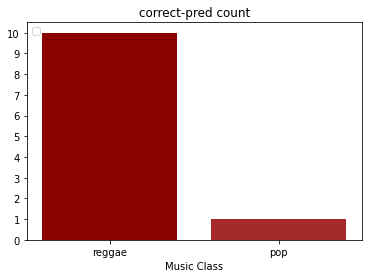

In [ ]:
table = result_df.copy(
table['ex_label'] = table['ex_label'].apply(cleaning)

colors1 = ['#8b0000', '#a52a2a', '#cd5c5c', '#f08080', '#fa8072',
          '#e9967a', '#ffa07a', '#ffdab9', '#ffe4c4', '#ffe4b5']

#제대로 분류한 애들
c2 = table[table['total_pred'] == table['ex_label']]
t2 = pd.DataFrame(c2['ex_label'].value_counts())
ratio2 = t2['ex_label']
labels2 = t2.index.tolist()
index2 = np.arange(0, max(ratio2)+1)

plt.bar(labels2, ratio2, color=colors1)
plt.title('correct-pred count')
plt.xlabel('Music Class')
plt.yticks(index2)
plt.legend(loc='upper left')

plt.show()

No handles with labels found to put in legend.


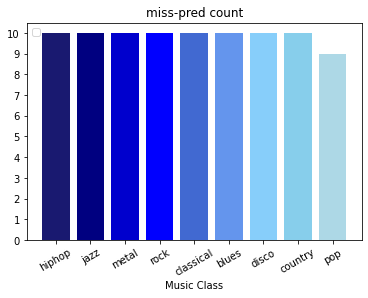

In [ ]:
colors2 = ['#191970', '#000080', '#0000cd', '#0000ff', '#4169d1',
           '#6495ed', '#87cefa', '#87ceeb', '#add8e6', '#b0e0e6']

#제대로 분류 못한 애들
c = table[table['total_pred'] != table['ex_label']]
tt = pd.DataFrame(c['ex_label'].value_counts())
ratio = tt['ex_label']
labels = tt.index.tolist()
index = np.arange(0, max(ratio)+1)

plt.bar(labels, ratio, color=colors2)
plt.title('miss-pred count')
plt.xlabel('Music Class')
plt.xticks(rotation=30)
plt.yticks(index)
plt.legend(loc='upper left')

plt.show()

No handles with labels found to put in legend.


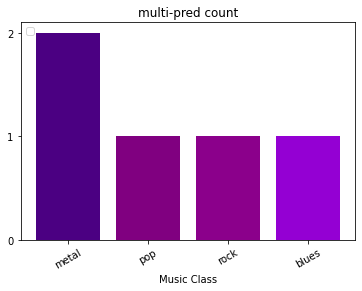

In [ ]:
colors3 = ['#4b0082', '#800080', '#8b008b', '#9400d3', '#9932cc',
           '#8a2be2', '#ba55d3', '#da70d6', '#ee82ee', '#dda0dd']

#제대로 분류 못한(중복으로 분류한) 애들
cc = table[table['total_pred'] == '-1']
tt2 = pd.DataFrame(cc['ex_label'].value_counts())
ratio22 = tt2['ex_label']
labels22 = tt2.index.tolist()
index22 = np.arange(0, max(ratio22)+1)

plt.bar(labels22, ratio22, color=colors3)
plt.title('multi-pred count')
plt.xlabel('Music Class')
plt.xticks(rotation=30)
plt.yticks(index22)
plt.legend(loc='upper left')

plt.show()